In [6]:
!pip install opencv-python
!pip install matplotlib
!pip install scipy
!pip install ipywidgets
!pip install scikit-learn

In [24]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import random

**Part 1**: Feature detection, description and matching part ; SIFT descriptor or the concatenated pixel values within a local window

In [8]:
def knn_matching_algorithm(des1, des2, k=2):
    #NearestNeighbors model using euclidean distance because faster.
    model = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
    model.fit(des2)
    distances, indices = model.kneighbors(des1)
    
    #Filter good matches based on the distances
    good_matches = []
    for i, (dist1, dist2) in enumerate(zip(distances[:, 0], distances[:, 1])):
        if dist1 < 0.75 * dist2:  
            good_matches.append((i, indices[i, 0], dist1))  
    
    return good_matches

In [40]:
def local_window_descriptors(gray, window_size=9, k=0.04, threshold=0.01):
    gray_float = np.float32(gray)
    corner_response = cv2.cornerHarris(gray_float, 2, 3, k)
    corner_response = cv2.dilate(corner_response, None)  
    corners = corner_response > threshold * corner_response.max()  
    half_size = window_size // 2
    descriptors = []
    valid_keypoints = []
    for y in range(half_size, gray.shape[0] - half_size):
        for x in range(half_size, gray.shape[1] - half_size):
            if corners[y, x]: #Only consider the points where a corner is detected
                window = gray[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]
                descriptor = window.flatten()#Flatten the window to a 1D descriptor
                valid_keypoints.append(cv2.KeyPoint(x, y, window_size))
                descriptors.append(descriptor)
    return valid_keypoints, np.array(descriptors)
def Finding_Matches(image1,image2,method='sift'):
    image1_gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
    if method =='sift': # SIFT algorithm
        # print('SIFT Algorithm')
        sift =cv2.SIFT_create()
        image1_kp,image1_des = sift.detectAndCompute(image1_gray,None)
        image2_kp,image2_des = sift.detectAndCompute(image2_gray,None)
    elif method== None :#local_window_descriptors
        # print('Local window')
        image1_kp,image1_des = local_window_descriptors(image1_gray)
        image2_kp,image2_des = local_window_descriptors(image2_gray)
    #i try to imlplement knn algorihtm for replace cv2.knn_matching that cannot use in this project
    good_matches = knn_matching_algorithm(image1_des, image2_des, k=2)
    return good_matches, image1_kp, image2_kp 

**Visualization Feature detection and Matching**

In [10]:
def DrawMatches(image1, image2, image1_kp, image2_kp, matches):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    combined_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    combined_img[:h1, :w1, :] = image1
    combined_img[:h2, w1:w1 + w2, :] = image2
    
    for match in matches:
        i, j, dist = match
        pt1 = (int(image1_kp[i].pt[0]), int(image1_kp[i].pt[1]))
        pt2 = (int(image2_kp[j].pt[0]) + w1, int(image2_kp[j].pt[1]))  # Add w1 to x-coordinate of second image
        color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for the match
        cv2.circle(combined_img, pt1, 5, color, -1)
        cv2.circle(combined_img, pt2, 5, color, -1)
        cv2.line(combined_img, pt1, pt2, color, 1)
    
    return combined_img

#Visualization use for visualizing photo with keypoints
def visualization_sift(image,keypoints):
    #Draw keypoint in images
    image_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(0, 255, 0))
    image_keypoints = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 3))
    plt.imshow(image_keypoints)
    plt.axis('off')
    plt.show()

**SIFT**

In [11]:
#Testing SIFT algorithm with two images
image1 = cv2.imread('data4/3.JPG')
image2 = cv2.imread('data4/4.JPG')
matching,kp1,kp2 =Finding_Matches(image1,image2,method='sift')
matching_image = DrawMatches(image1,image2,kp1,kp2, matching)

SIFT Algorithm


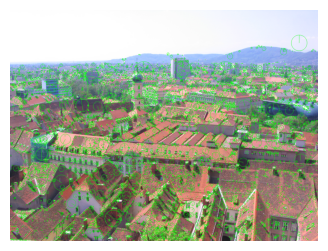

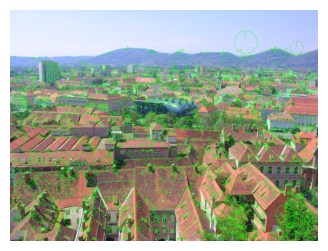

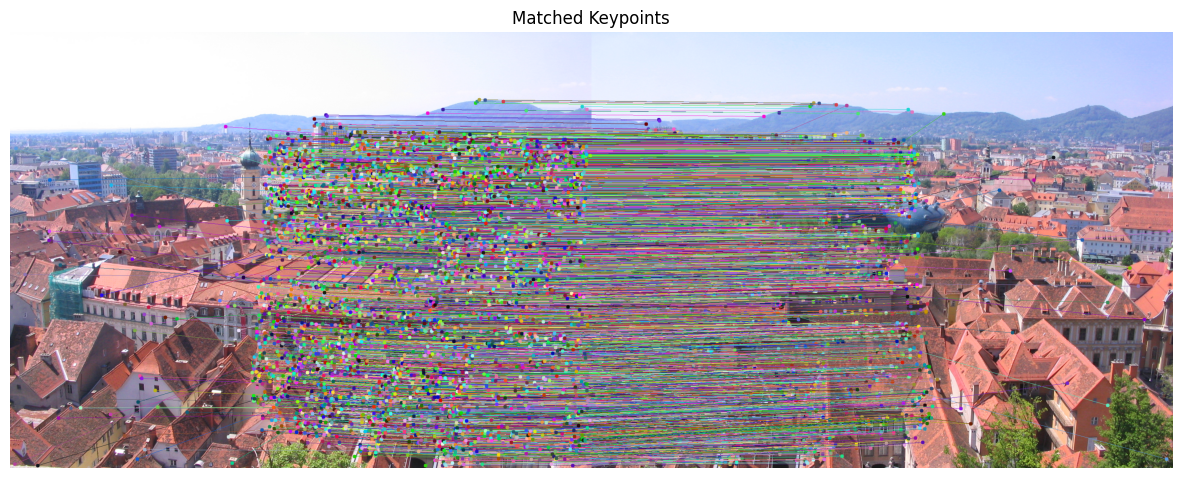

In [12]:
visualization_sift(image1,kp1)
visualization_sift(image2,kp2)
#Display photo with matching feature
cv2.imwrite('matching_result/sift/data4.jpg', matching_image)
plt.figure(figsize=(15, 6))
plt.imshow(cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.title('Matched Keypoints')
plt.show()


**Local Window Descriptors**

Local window


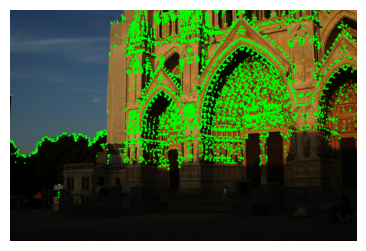

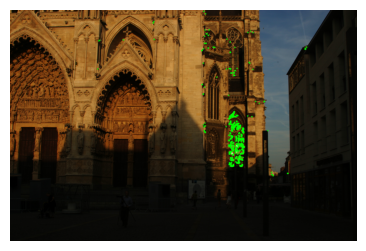

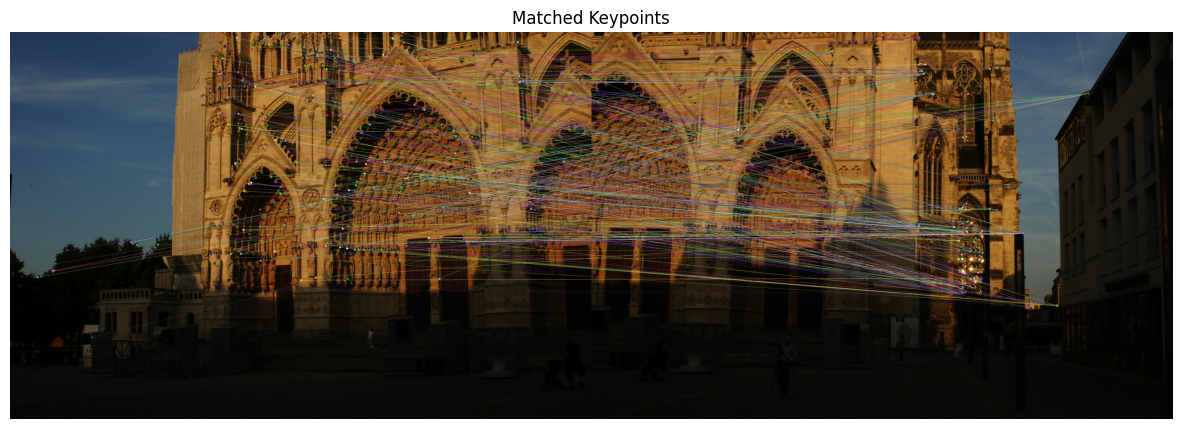

In [13]:
#Display for local window Description
image1 = cv2.imread('data1/1.JPG')
image2 = cv2.imread('data1/2.JPG')
matching,kp1,kp2 =Finding_Matches(image1,image2,method=None) #Change the method into None -> meaning for local window , 'sift' for SIFT algorithm
matching_image = DrawMatches(image1,image2,kp1,kp2, matching)
visualization_sift(image1,kp1)
visualization_sift(image2,kp2)
cv2.imwrite('matching_result/local_window/data1.jpg', matching_image)
plt.figure(figsize=(15, 6))
plt.imshow(cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Matched Keypoints')
plt.show()

**Part 2**:Estimation of homography

In [14]:
def ComputeRansacIterations(outlier_ratio, success_prob=0.99):
    if outlier_ratio == 1:
        return 0 #if rasnac algorithm cannot solve it return zero
    return math.ceil(math.log(1 - success_prob) / math.log(1 - (1 - outlier_ratio)**4))
def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code
    if len(Matches) < 4:
        print("Not enough matches found between the images.")
        exit(0)
    Image1_pts = []
    Image2_pts = []
    for Match in Matches:
        i, j, dist = Match 
        Image1_pts.append(BaseImage_kp[i].pt) 
        Image2_pts.append(SecImage_kp[j].pt)
    Image1_pts = np.float32(Image1_pts)
    Image2_pts = np.float32(Image2_pts)
    #Finding the homography matrix using RANSAC
    HomographyMatrix, Status = cv2.findHomography(Image2_pts, Image1_pts, cv2.RANSAC, 4.0)
    #Compute the number of inliers and outliers
    inliers = Status.ravel().tolist()
    inlier_count = sum(inliers)
    outlier_count = len(inliers) - inlier_count
    outlier_ratio = outlier_count / len(inliers) if len(inliers) > 0 else 0
    #Compute the outlier ratio
    iterations_needed = ComputeRansacIterations(outlier_ratio)
    print(f"Outlier Ratio: {outlier_ratio:.4f}")
    print(f"Minimum RANSAC Iterations: {iterations_needed}")
    return HomographyMatrix, Status


This would be the code to project an image onto the surface of a cylinder, a common step in stitching panoramas or creating a cylindrical projection for 360-degree images. The Convert_xy function would probably implement the math of the cylindrical projection, mapping pixel coordinates from a flat image onto the curved surface of a cylinder. The result is an image that has the appearance of being wrapped around some cylindrical object, simulating how objects would appear in such a projection.

In [15]:
def Transforming_xy(x, y):
    global center, f
    dx = x - center[0]
    dy = y - center[1]
    xt = f * np.tan(dx / f) + center[0]
    yt = dy / np.cos(dx / f) + center[1]
    return xt, yt
def ProjectOntoCylinder(OriginalImage):
    global w, h, center, f
    h, w = OriginalImage.shape[:2]
    center = [w // 2, h // 2]
    f = 1100
    CylindricalImage = np.zeros(OriginalImage.shape, dtype=np.uint8)
    #Generating all coordinates (x, y)
    Coordinates = np.array([np.array([i, j]) for i in range(w) for j in range(h)])
    transformed_x = Coordinates[:, 0]
    transformed_y = Coordinates[:, 1]
    #Converting the coordinates to cylindrical coordinates
    original_x, original_y = Transforming_xy(transformed_x, transformed_y)
    original_tl_x = original_x.astype(int)
    original_tl_y = original_y.astype(int)
    #Filtering out coordinates
    valid_indices = (original_tl_x >= 0) * (original_tl_x <= (w - 2)) * \
                    (original_tl_y >= 0) * (original_tl_y <= (h - 2))
    transformed_x = transformed_x[valid_indices]
    transformed_y = transformed_y[valid_indices]
    original_x = original_x[valid_indices]
    original_y = original_y[valid_indices]
    original_tl_x = original_tl_x[valid_indices]
    original_tl_y = original_tl_y[valid_indices]
    #Bilinear interpolation to map pixel values
    dx = original_x - original_tl_x
    dy = original_y - original_tl_y
    weight_tl = (1.0 - dx) * (1.0 - dy)
    weight_tr = (dx) * (1.0 - dy)
    weight_bl = (1.0 - dx) * (dy)
    weight_br = (dx) * (dy)
    # Apply bilinear interpolation
    CylindricalImage[transformed_y, transformed_x, :] = (weight_tl[:, None] * OriginalImage[original_tl_y, original_tl_x, :]) + \
                                                          (weight_tr[:, None] * OriginalImage[original_tl_y, original_tl_x + 1, :]) + \
                                                          (weight_bl[:, None] * OriginalImage[original_tl_y + 1, original_tl_x, :]) + \
                                                          (weight_br[:, None] * OriginalImage[original_tl_y + 1, original_tl_x + 1, :])
    min_x = min(transformed_x)
    CylindricalImage = CylindricalImage[:, min_x: -min_x, :]
    return CylindricalImage, transformed_x - min_x, transformed_y


The function GetTransformMatrix will estimate the size of the transformed stitched image and update the homography matrix. Inputs to this function are the homography matrix (HMatrix), dimensions of the secondary image, SecImgShape, and Base image, BaseImgShape. First, the transformed coordinates of the secondary image corners are calculated by multiplying them with the homography matrix:. Second, it calculates the new width and height of the stitched image, taking as considerations the limits where the transformed image would fit inside the base image. In case the secondary image falls out of the base image, it readjusts the dimensions, considering the correction factor. Finally, it updates the homography matrix in order to correctly position the secondary image within this new frame. It returns the new dimensions of the image, the correction factor, and the homography matrix corrected.








In [16]:
def GetFrameSizeAndTransformMatrix(HMatrix, SecImgShape, BaseImgShape):
    (H, W) = SecImgShape
    InitMatrix = np.array([[0, W - 1, W - 1, 0],[0, 0, H - 1, H - 1],[1, 1, 1, 1]])
    FinalMatrix = np.dot(HMatrix, InitMatrix)
    #Making the matrix of intial coordinate of the corners of the second image
    [X, Y, C] = FinalMatrix
    X = np.divide(X, C)
    Y = np.divide(Y, C)
    # Finding the dimensions of the stitched image
    minX, maxX = int(round(min(X))), int(round(max(X)))
    minY, maxY = int(round(min(Y))), int(round(max(Y)))
    NewW = maxX
    NewH = maxY
    Corr = [0, 0]
    if minX < 0:
        NewW -= minX
        Corr[0] = abs(minX)
    if minY < 0:
        NewH -= minY
        Corr[1] = abs(minY)
    if NewW < BaseImgShape[1] + Corr[0]:
        NewW = BaseImgShape[1] + Corr[0]
    if NewH < BaseImgShape[0] + Corr[1]:
        NewH = BaseImgShape[0] + Corr[1]
    # Finding the coordinates of the corners of the image.
    X = np.add(X, Corr[0])
    Y = np.add(Y, Corr[1])
    OldInitPoints = np.float32([[0, 0],
                                [W - 1, 0],
                                [W - 1, H - 1],
                                [0, H - 1]])
    NewFinalPoints = np.float32(np.array([X, Y]).transpose())
    HMatrix = cv2.getPerspectiveTransform(OldInitPoints, NewFinalPoints)
    return [NewH, NewW], Corr, HMatrix


Part 3 & 4 :Image stitching and Comparison of different feature descriptors

In [17]:
def StitchImages(image1, image2):
    SecImg_Cyl, mask_x, mask_y = ProjectOntoCylinder(image2)
    SecImg_Mask = np.zeros(SecImg_Cyl.shape, dtype=np.uint8)
    SecImg_Mask[mask_y, mask_x, :] = 255
    #Finding matches and keypoints between image1 and image2, by using sift or None = Local window 
    Matches, Base_kp, Sec_kp = Finding_Matches(image1, SecImg_Cyl,'sift')
    # Compute homography matrix
    HMatrix, Status = FindHomography(Matches, Base_kp, Sec_kp)
    NewSize, Corr, HMatrix = GetFrameSizeAndTransformMatrix(HMatrix, SecImg_Cyl.shape[:2], image1.shape[:2])
    #Transforming image2 to new frame
    SecImg_Tf = cv2.warpPerspective(SecImg_Cyl, HMatrix, (NewSize[1], NewSize[0]))
    SecImg_Mask_Tf = cv2.warpPerspective(SecImg_Mask, HMatrix, (NewSize[1], NewSize[0]))
    #Preparing image1 for blending
    BaseImg_Tf = np.zeros((NewSize[0], NewSize[1], 3), dtype=np.uint8)
    BaseImg_Tf[Corr[1]:Corr[1]+image1.shape[0], Corr[0]:Corr[0]+image1.shape[1]] = image1
    StitchedImg = cv2.bitwise_or(SecImg_Tf, cv2.bitwise_and(BaseImg_Tf, cv2.bitwise_not(SecImg_Mask_Tf)))
    return StitchedImg


Load dataset 

In [18]:
#loading dataset base on dataset name
def load_images(dataset):
    data1=['data1/1.JPG','data1/2.JPG','data1/3.JPG','data1/4.JPG','data1/5.JPG','data1/6.JPG']
    data2 =['data2/1.JPG','data2/2.JPG','data2/3.JPG','data2/4.JPG']
    data3 =['data3/1.JPG','data3/2.JPG','data3/3.JPG']
    data4 = ['data4/1.JPG','data4/2.JPG','data4/3.JPG','data4/4.JPG']
    #Choosing base on dataset input
    if dataset =='data1':
        image_paths = data1
    elif dataset == 'data2':
        image_paths = data2
    elif dataset == 'data3':
        image_paths = data3
    else:
        image_paths = data4
    return [cv2.imread(path) for path in image_paths]

In [19]:
def main(dataset='data1'):
#reading and load image from database 
    Images = load_images(dataset)
    #finding the base image, like the center of photo
    if dataset=='data1':
        base = 3 # for local window base == 2
    elif dataset=='data2':
        base = 2
    elif dataset=='data3':
        base = 1
    elif dataset =='data4' :
        base = 1
    BaseImage,_,_ = ProjectOntoCylinder(Images[base]) #making 360 degree images
    for i in range(0,len(Images)):
        if i == base : continue
        StitchedImage = StitchImages(BaseImage, Images[i])
        BaseImage = StitchedImage.copy()
    result_name = "result/"+dataset+".jpg"
    cv2.imwrite(result_name, BaseImage)


In [20]:
if __name__=="__main__":
    dataset = ['data1','data2','data3','data4']
    for path in dataset:
        print("++++++++++++++++++++++++++++++++")
        print(path, " SIFT")
        main(path)
        print("++++++++++++++++++++++++++++++++")

++++++++++++++++++++++++++++++++
data1  SIFT
SIFT Algorithm
Outlier Ratio: 0.7753
Minimum RANSAC Iterations: 1805
SIFT Algorithm
Outlier Ratio: 0.4643
Minimum RANSAC Iterations: 54
SIFT Algorithm
Outlier Ratio: 0.5447
Minimum RANSAC Iterations: 105
SIFT Algorithm
Outlier Ratio: 0.7527
Minimum RANSAC Iterations: 1230
SIFT Algorithm
Outlier Ratio: 0.4594
Minimum RANSAC Iterations: 52
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
data2  SIFT
SIFT Algorithm
Outlier Ratio: 0.0417
Minimum RANSAC Iterations: 3
SIFT Algorithm
Outlier Ratio: 0.1944
Minimum RANSAC Iterations: 9
SIFT Algorithm
Outlier Ratio: 0.1919
Minimum RANSAC Iterations: 9
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
data3  SIFT
SIFT Algorithm
Outlier Ratio: 0.0716
Minimum RANSAC Iterations: 4
SIFT Algorithm
Outlier Ratio: 0.0244
Minimum RANSAC Iterations: 2
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
data4  SIFT
SIFT Algorithm
Outlier Ratio: 0.2414
Minimum RANSAC

TESTING n test and acceptance rate 50%

In [37]:
def ComputeRansacIterations(outlier_ratio, success_prob=0.5):
    if outlier_ratio == 1:
        return 0 #if rasnac algorithm cannot solve it return zero
    return math.ceil(math.log(1 - success_prob) / math.log(1 - (1 - outlier_ratio)**4))

def Testing(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code
    if len(Matches) < 4:
        print("Not enough matches found between the images.")
        exit(0)
    Image1_pts = []
    Image2_pts = []
    for Match in Matches:
        i, j, dist = Match 
        Image1_pts.append(BaseImage_kp[i].pt) 
        Image2_pts.append(SecImage_kp[j].pt)
    Image1_pts = np.float32(Image1_pts)
    Image2_pts = np.float32(Image2_pts)
    #Finding the homography matrix using RANSAC
    HomographyMatrix, Status = cv2.findHomography(Image2_pts, Image1_pts, cv2.RANSAC, 4.0)
    #Compute the number of inliers and outliers
    inliers = Status.ravel().tolist()
    inlier_count = sum(inliers)
    outlier_count = len(inliers) - inlier_count
    outlier_ratio = outlier_count / len(inliers) if len(inliers) > 0 else 0
    #Compute the outlier ratio
    iterations_needed = ComputeRansacIterations(outlier_ratio)
    return iterations_needed ,outlier_ratio


In [44]:
def main():
    dataset = ['data1','data2','data3','data4']
    num_iteration =20
    for data in dataset:
        outlier,iteration =[],[]
        images = load_images(data)
        for _ in range(num_iteration):
            img1, img2 = random.sample(images, 2)
            # img1 = ProjectOntoCylinder(img1)
            SecImg_Cyl, mask_x, mask_y = ProjectOntoCylinder(img2)
            SecImg_Mask = np.zeros(SecImg_Cyl.shape, dtype=np.uint8)
            SecImg_Mask[mask_y, mask_x, :] = 255
            Matches, Base_kp, Sec_kp = Finding_Matches(img1, SecImg_Cyl,None)
            iterations_needed ,outlier_ratio =Testing(Matches, Base_kp, Sec_kp)
            outlier.append(outlier_ratio)
            iteration.append(iterations_needed)
        print(f"{data} : average of outlier : {sum(outlier) / len(outlier):.2f}, minimum iteration after 25 tests: {min(iteration)}")
    
main()
            
            

data1 : average of outlier : 0.72, minimum iteration after 25 tests: 11
data2 : average of outlier : 0.23, minimum iteration after 25 tests: 1
data3 : average of outlier : 0.12, minimum iteration after 25 tests: 1
data4 : average of outlier : 0.62, minimum iteration after 25 tests: 4


In [45]:
def main():
    dataset = ['data1','data2','data3','data4']
    num_iteration =20
    for data in dataset:
        outlier,iteration =[],[]
        images = load_images(data)
        for _ in range(num_iteration):
            img1, img2 = random.sample(images, 2)
            # img1 = ProjectOntoCylinder(img1)
            SecImg_Cyl, mask_x, mask_y = ProjectOntoCylinder(img2)
            SecImg_Mask = np.zeros(SecImg_Cyl.shape, dtype=np.uint8)
            SecImg_Mask[mask_y, mask_x, :] = 255
            Matches, Base_kp, Sec_kp = Finding_Matches(img1, SecImg_Cyl,None)
            iterations_needed ,outlier_ratio =Testing(Matches, Base_kp, Sec_kp)
            outlier.append(outlier_ratio)
            iteration.append(iterations_needed)
        print(f"{data} : average of outlier : {sum(outlier) / len(outlier):.2f}, minimum iteration after 25 tests: {min(iteration)}")
    
main()

data1 : average of outlier : 0.65, minimum iteration after 25 tests: 2
data2 : average of outlier : 0.21, minimum iteration after 25 tests: 1
data3 : average of outlier : 0.07, minimum iteration after 25 tests: 1
data4 : average of outlier : 0.55, minimum iteration after 25 tests: 2
